[*********************100%%**********************]  1 of 1 completed


Cumulative Returns: 328.49%
Annualized Returns: 16.43%
Sharpe Ratio: 0.76
Max Drawdown: -42.22%
Calmar Ratio: 0.39
Sortino Ratio: 0.85

Year-over-Year (YoY) Growth:
Year
2015          NaN
2016     7.503472
2017    46.080160
2018    -7.323550
2019    44.602676
2020    80.555742
2021    33.779109
2022   -24.453091
2023    21.085342
2024    -7.853760
Name: Portfolio Value, dtype: float64


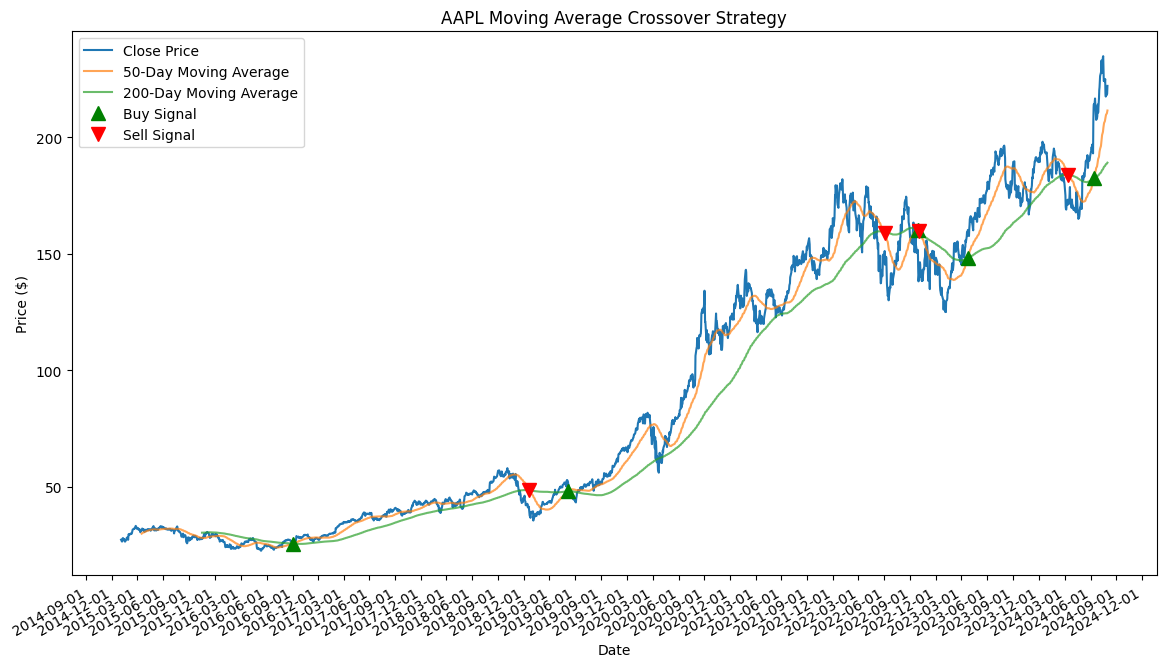

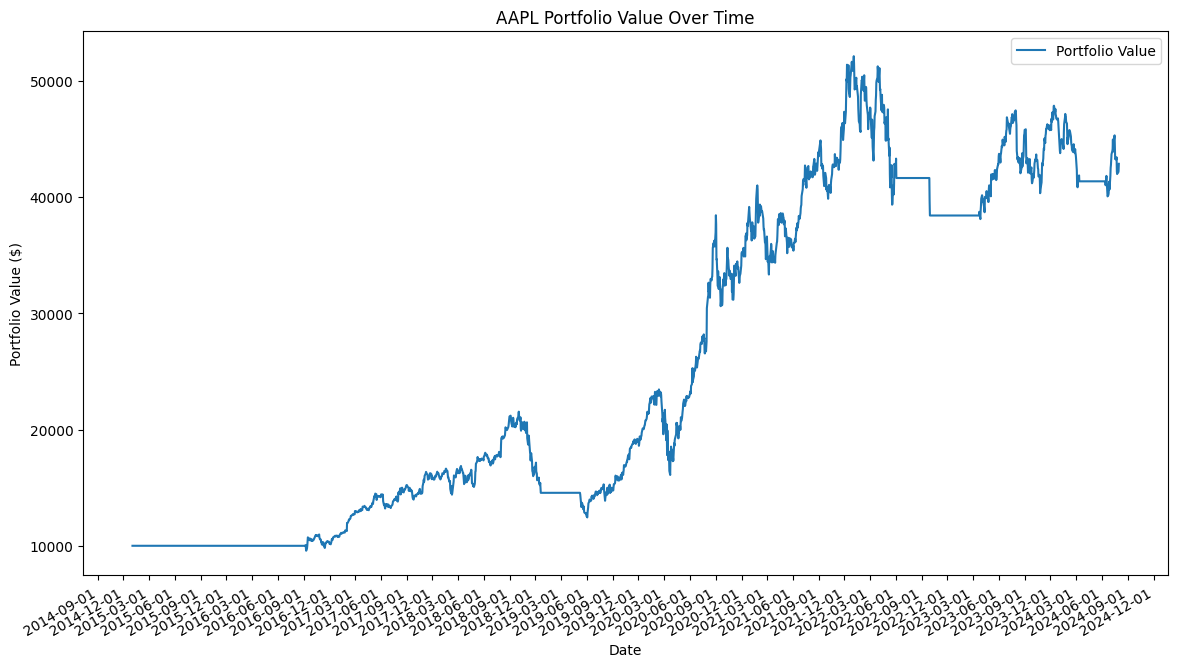

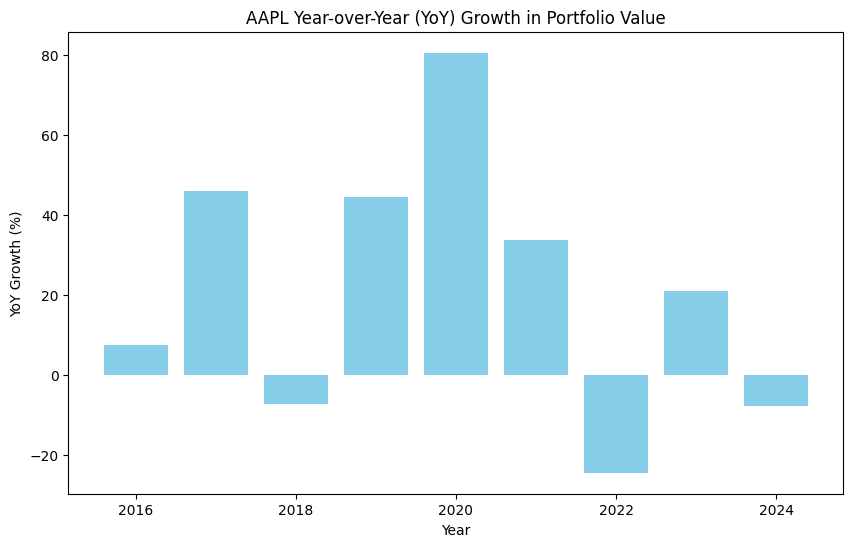

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Download Historical Data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-08-01'

# Fetch stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Implement Moving Average Crossover Strategy
# Calculate the moving averages
data['Short_MA'] = data['Close'].rolling(window=50).mean()
data['Long_MA'] = data['Close'].rolling(window=200).mean()

# Generate buy/sell signals
data['Signal'] = 0
data.loc[data.index[50:], 'Signal'] = np.where(data['Short_MA'].iloc[50:] > data['Long_MA'].iloc[50:], 1, 0)
data['Position'] = data['Signal'].diff()

# Step 3: Backtest the Strategy with Executed Buy/Sell Signals
initial_capital = 10000.0
shares_held = 0
portfolio_value = []
cash = initial_capital

for i in range(len(data)):
    if data['Position'].iloc[i] == 1:  # Buy signal
        shares_held = cash // data['Close'].iloc[i]
        cash -= shares_held * data['Close'].iloc[i]
    elif data['Position'].iloc[i] == -1:  # Sell signal
        cash += shares_held * data['Close'].iloc[i]
        shares_held = 0
    
    portfolio_value.append(cash + shares_held * data['Close'].iloc[i])

data['Portfolio Value'] = portfolio_value

# Step 4: Calculate and Display the Strategy's Performance Metrics
# Cumulative returns
cumulative_returns = (data['Portfolio Value'].iloc[-1] / initial_capital) - 1

# Annualized return
annualized_return = (1 + cumulative_returns) ** (252 / len(data)) - 1

# Sharpe ratio
sharpe_ratio = (data['Portfolio Value'].pct_change().mean() / data['Portfolio Value'].pct_change().std()) * np.sqrt(252)

# Year-over-Year (YoY) growth in portfolio value
data['Year'] = data.index.year
yoy_growth = data.groupby('Year')['Portfolio Value'].last().pct_change() * 100

# Maximum drawdown
data['Cumulative Max'] = data['Portfolio Value'].cummax()
data['Drawdown'] = data['Portfolio Value'] / data['Cumulative Max'] - 1
max_drawdown = data['Drawdown'].min()

# Calmar Ratio (Annualized Return / Maximum Drawdown)
calmar_ratio = annualized_return / abs(max_drawdown)

# Sortino Ratio (assuming risk-free rate is 0 for simplicity)
downside_returns = data['Portfolio Value'].pct_change()[data['Portfolio Value'].pct_change() < 0]
sortino_ratio = data['Portfolio Value'].pct_change().mean() / downside_returns.std() * np.sqrt(252)

# Print the results
print(f"Cumulative Returns: {cumulative_returns * 100:.2f}%")
print(f"Annualized Returns: {annualized_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print("\nYear-over-Year (YoY) Growth:")
print(yoy_growth)

# Step 5: Plot the Strategy's Performance and Buy/Sell Signals
plt.figure(figsize=(14, 8))

# Plot the closing price
plt.plot(data.index, data['Close'], label='Close Price')

# Plot the short and long-term moving averages
plt.plot(data.index, data['Short_MA'], label='50-Day Moving Average', alpha=0.7)
plt.plot(data.index, data['Long_MA'], label='200-Day Moving Average', alpha=0.7)

# Mark buy and sell signals
plt.plot(data[data['Position'] == 1].index, data['Short_MA'][data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['Short_MA'][data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

# Formatting the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()

# Adding title and labels
plt.title(f'{ticker} Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value')
plt.title(f'{ticker} Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Plot YoY growth
plt.figure(figsize=(10, 6))
plt.bar(yoy_growth.index[1:], yoy_growth[1:], color='skyblue')
plt.title(f'{ticker} Year-over-Year (YoY) Growth in Portfolio Value')
plt.xlabel('Year')
plt.ylabel('YoY Growth (%)')
plt.show()
